<a href="https://colab.research.google.com/github/OscarRojasG/ADA-Informes/blob/main/Informe11-BellmanFord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Problema del camino más corto 

**Entrada**: Un grafo dirigido $G=(V,E)$, un vértice fuente $s\in V$, y un valor real $l_e$ asociado a cada arco $e\in E$.

**Salida**: La distancia más corta $\text{dist}(s,v)$ para cada vértice $v\in V$, o una declaración indicando que $G$ contiene un ciclo negativo.

El problema del camino más corto consiste en encontrar la distancia mínima que existe entre un vértice $s$ y cada uno de los nodos de un grafo $G$. La distancia entre un nodo y otro se calcula sumando los pesos de los arcos que hay entre ellos. 

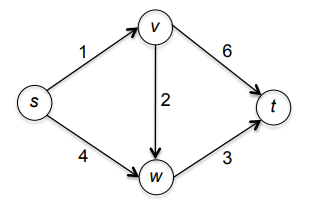

En el ejemplo anterior, supongamos que queremos calcular la distancia mínima de $s$ a $t$. Para llegar a este último nodo, existen varios caminos posibles. Por ejemplo, si calculamos la distancia del camino $s \leadsto v \leadsto w \leadsto t$, obtenemos un valor de 6, mientras que al calcular la distancia de los caminos $s \leadsto v \leadsto t$ y $s \leadsto w \leadsto t$ se obtiene una distancia de 7. En este caso, es el camino $s \leadsto v \leadsto w \leadsto t$ aquel que minimiza la distancia.

Existen varios algoritmos que resuelven este problema, por ejemplo, el **algoritmo de Dijkstra**, de naturaleza greedy, o el **algoritmo de Bellman-Ford**, que utiliza la técnica de programación dinámica. Una de las principales características que diferencia al algoritmo de Bellman-Ford de Dijkstra, es su capacidad de trabajar con arcos de peso negativo, ampliando el espectro de problemas que pueden resolverse con este algoritmo. Sin embargo, Dijkstra posee un menor tiempo de ejecución, por lo cual dependerá del contexto del problema el algoritmo a utilizar.

Algunas aplicaciones de este problema son, por ejemplo, encontrar la ruta más corta de una ciudad a otra, principalmente utilizado por los sistemas de navegación (GPS), o el enrutamiento de paquetes para la transmisión de datos por la red.

# 2. Algoritmo de Bellman-Ford y Dijkstra

## 2.1 Código

### Funciones auxiliares

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def draw_edge_labels(G, pos, edge_labels=None, label_pos=0.5, 
                     font_size=10, font_color="k", font_family="sans-serif", 
                     font_weight="normal", alpha=None, bbox=None,
                     horizontalalignment="center", verticalalignment="center",
                     ax=None, rotate=True, clip_on=True, rad=0):
  if ax is None:
    ax = plt.gca()
  if edge_labels is None:
    labels = {(u, v): d for u, v, d in G.edges(data=True)}
  else:
    labels = edge_labels

  text_items = {}
  for (n1, n2), label in labels.items():
    (x1, y1) = pos[n1]
    (x2, y2) = pos[n2]
    (x, y) = (
        x1 * label_pos + x2 * (1.0 - label_pos),
        y1 * label_pos + y2 * (1.0 - label_pos),
    )
    pos_1 = ax.transData.transform(np.array(pos[n1]))
    pos_2 = ax.transData.transform(np.array(pos[n2]))
    linear_mid = 0.5*pos_1 + 0.5*pos_2
    d_pos = pos_2 - pos_1
    rotation_matrix = np.array([(0,1), (-1,0)])
    ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
    ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
    ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
    bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
    (x, y) = ax.transData.inverted().transform(bezier_mid)

    if rotate:
      angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
      if angle > 90:
        angle -= 180
      if angle < -90:
        angle += 180
      xy = np.array((x, y))
      trans_angle = ax.transData.transform_angles(
          np.array((angle,)), xy.reshape((1, 2))
      )[0]
    else:
      trans_angle = 0.0

      if bbox is None:
          bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
      if not isinstance(label, str):
          label = str(label)

    ax.text(x, y, label, size=font_size, color=font_color, 
            family=font_family, weight=font_weight, alpha=alpha,
            horizontalalignment=horizontalalignment, 
            verticalalignment=verticalalignment,
            rotation=trans_angle, transform=ax.transData, bbox=bbox,
            zorder=1, clip_on=clip_on)

  ax.tick_params(
      axis="both",
      which="both",
      bottom=False,
      left=False,
      labelbottom=False,
      labelleft=False,
  )

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph(G):
  pos = nx.spring_layout(G, k=2.25, seed=1)
  nx.draw(G, pos, node_size=1000, node_color='white', edgecolors='black', edgelist=[])
  nx.draw_networkx_labels(G, pos, font_size=12)

  curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
  straight_edges = list(set(G.edges()) - set(curved_edges))

  nx.draw_networkx_edges(G, pos, edgelist=straight_edges, node_size=1000)
  nx.draw_networkx_edges(G, pos, edgelist=curved_edges, node_size=1000,
                        connectionstyle=f'arc3, rad=0.25')

  edge_weights = nx.get_edge_attributes(G, 'weight')
  curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
  straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
  draw_edge_labels(G, pos, edge_labels=curved_edge_labels, rotate=False, rad=0.25)
  draw_edge_labels(G, pos, edge_labels=straight_edge_labels, rotate=False)

In [3]:
import networkx as nx

def create_graph(edges):
  graph = nx.DiGraph()
  graph.add_weighted_edges_from(edges)
  
  return graph

### Bellman-Ford

In [45]:
from termcolor import colored
from math import inf

def bellman_ford(G, s, visualize = False, verbose = False):
  size = len(G.nodes())
  distance = [0] * size # Almacena la distancia de s a cada nodo

  for n in G.nodes():
    distance[n] = inf # Inicializamos la distancia a cada nodo en infinito

  distance[s] = 0 # Inicializamos el nodo de partida con distancia cero

  if verbose:
    print(f"Inicializando nodo {colored(s, 'magenta')} con distancia 0")
    print(f"Inicializando resto de nodos con distancia infinita")

  for i in range(size - 1): # Se recorren los arcos del grafo V - 1 veces
    changed = False # Revisa si hubo cambios en la iteración actual

    if verbose:
      print(f"\nIteración {i+1}:\n")

    for e in G.edges():
      u, v = e[0], e[1]    
      d = distance[u] + G[u][v]['weight'] # Calculamos la distancia

      if verbose:
        print(f"Calculando distancia al nodo {colored(v, 'magenta')} ", end='')
        print(f"con nodo predecesor {colored(u, 'blue')}: ", end='')
        print(f"{distance[u]} + {G[u][v]['weight']} = {colored(d, 'green')}")

      if d < distance[v]: # Si la distancia es menor la actualizamos
        if verbose:
          print(f"Distancia ({colored(d, 'green')}) es menor ", end='')
          print(f"a la actual ({distance[v]}). Actualizando...")

        distance[v] = d
        changed = True

      else:
        if verbose:
          print(f"Distancia ({colored(d, 'green')}) es mayor ", end='')
          print(f"a la actual ({d})")

    # Si no hubo cambios en la última iteración, rompemos el ciclo
    if changed == False: 
      if verbose:
        print(f"\nNo hubo cambios en la última iteración. Rompiendo ciclo...\n")
      break

  if visualize: draw_graph(G)

  if changed == True:
    if verbose:
      print(f"\nIterando una última vez para detectar ciclos negativos...\n")

    # Se vuelven a recorrer los arcos para revisar si existen ciclos negativos
    for e in G.edges():
      u, v = e[0], e[1]    
      d = distance[u] + G[u][v]['weight']

      if d < distance[v]:
        if verbose: print(f"Ciclo negativo detectado.")
        return list() # Si existe un ciclo negativo retornamos una lista vacía

  if verbose: print(f"Distancias: {distance}")

  return distance

Distancias: [0, 2, 4, 7, -2]


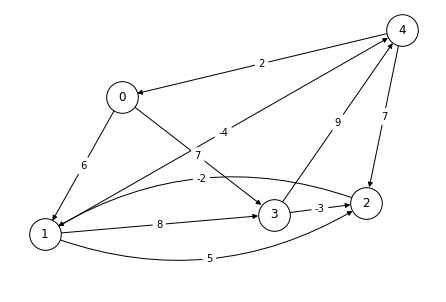

In [5]:
edges = [
  (0, 1,  6),
  (0, 3,  7),
  (1, 2,  5),
  (1, 3,  8),
  (1, 4, -4),
  (2, 1, -2),
  (3, 2, -3),
  (3, 4,  9),
  (4, 0,  2),
  (4, 2,  7)
]

G = create_graph(edges)
d = bellman_ford(G, 0, True)
print(f"Distancias: {d}")

### Dijkstra

In [20]:
class Node:
  def __init__(self, key, priority):
    self.key = key
    self.priority = priority

class Heap:
  def __init__(self):
    self.A = list()
    self.size = 0

  def insert(self, key, priority):
    node = Node(key, priority)

    if self.size == len(self.A): self.A.append(node)
    else: self.A[self.size] = node
    curr = self.size

    while True:  
      if curr == 0: break
      parent = (curr-1)//2

      if self.A[parent].priority > node.priority:
        curr = parent
      else: break

    self.A[self.size], self.A[curr] = self.A[curr], self.A[self.size]
    self.size += 1

  def pop(self):
    if self.size == 0: return

    node = self.A[0]
    self.A[0] = self.A[self.size-1]
    self.size -= 1
    curr = 0

    while True:
      left = curr*2+1
      right = curr*2+2
      aux = curr

      if left < self.size and self.A[left].priority < self.A[curr].priority:
        curr = left

      if right < self.size and self.A[right].priority < self.A[curr].priority:
        curr = right

      if curr == aux: break
      self.A[aux], self.A[curr] = self.A[curr], self.A[aux]

    return node

  def is_empty(self):
    if self.size == 0: return True
    return False

  def get_nodes(self):
    return self.A

In [54]:
from termcolor import colored
from math import inf

def dijkstra(G, s, visualize = False, verbose = False):
  size = len(G.nodes())
  distance = [0] * size # Almacena la distancia de s a cada nodo
  visited = [False] * size # Almacena el estado de cada nodo (visitado = True)

  Q = Heap() # Creamos un montículo de mínimos para guardar los nodos

  for n in G.nodes():
    if n != s: 
      distance[n] = inf # Inicializamos la distancia a cada nodo en infinito
      Q.insert(n, distance[n]) # Insertamos los nodos en el montículo

  if verbose: 
    print(f"Inicializando montículo para guardar los nodos")
    print(f"Insertando nodos ", end='')
    print(', '.join([str(node.key) for node in Q.get_nodes()]), end=' ')
    print(f"con distancia infinita")
    print(f"Insertando nodo {s} con distancia 0")

  distance[s] = 0 # Inicializamos el nodo de partida con distancia cero
  Q.insert(s, distance[s]) # Insertamos el nodo 's' en el montículo

  while not Q.is_empty():
    u = Q.pop().key # Eliminamos el nodo con menor distancia del montículo
    if visited[u]: continue # Si el nodo ya fue visitado lo saltamos

    visited[u] = True # Marcamos el nodo como visitado
    adj = G[u] # Obtenemos los nodos adyacentes

    if verbose: 
      print(f"\nVisitando nodo {colored(u, 'magenta')}")
      print(f"Obteniendo nodos adyacentes: ", end='')
      print(', '.join([str(node) for node in adj]))

    for v in adj:

      if not visited[v]:
        d = distance[u] + G[u][v]['weight'] # Calculamos la distancia

        if verbose:
          print(f"Calculando distancia al nodo {colored(v, 'blue')}: ", end='')
          print(f"{distance[u]} + {G[u][v]['weight']} = {colored(d, 'green')}")

        if d < distance[v]: # Si la distancia es menor la actualizamos
          if verbose:
            print(f"Distancia ({colored(d, 'green')}) es menor ", end='')
            print(f"a la actual ({distance[v]}). Actualizando...")

          distance[v] = d
          Q.insert(v, d) # Insertamos este nodo en el montículo

      else:
        if verbose:
          print(f"Saltando nodo {colored(v, 'blue')} ya visitado")

  if visualize: draw_graph(G)
  if verbose: print(f"\nDistancias: {distance}")

  return distance

Distancias: [0, 8, 9, 5, 7]


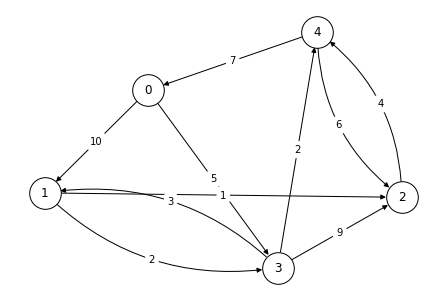

In [48]:
edges = [
  (0, 1, 10),
  (0, 3, 5),
  (1, 2, 1),
  (1, 3, 2),
  (2, 4, 4),
  (3, 1, 3),
  (3, 2, 9),
  (3, 4, 2),
  (4, 0, 7),
  (4, 2, 6)
]

G = create_graph(edges)
d = dijkstra(G, 0, True)
print(f"Distancias: {d}")

## 2.2. Descripción del algoritmo

### Bellman-Ford



La entrada consiste en un grafo dirigido $G$ con $n$ vértices, donde cada arco posee un peso asignado (distancia), más un nodo $s$ que corresponde al punto de partida. Si no existen ciclos negativos, el algoritmo retorna una lista con la distancia mínima que existe entre el nodo inicial y el resto de nodos del grafo. En caso contrario, el algoritmo retorna una lista vacía. Los pasos realizados son los siguientes:

1. Se crea una lista para guardar la distancia mínima de $s$ al resto de nodos, inicializando sus valores en infinito.

2. Asignamos al nodo $s$ una distancia de 0, puesto que corresponde al nodo inicial.

3. Iteramos $V-1$ veces por todos los arcos del grafo o hasta que no existan más cambios en las distancias (lo que ocurra primero).

4. Para cada arco $(u, v)$, calculamos la distancia de $s$ a $v$ como $\text{dist}(s, v) = \text{dist}(s, u) + w(u, v)$, donde $w(u, v)$ corresponde al peso del arco $(u, v)$.

5. Si la distancia calculada en el paso anterior es menor a la actual, actualizamos su valor.

6. Al finalizar las iteraciones, realizamos una última iteración adicional para verificar que no existan ciclos negativos. Si para cualquier arco $(u, v)$ obtenemos una distancia menor a las previamente calculadas, retornamos una lista vacía.

7. Si no existen ciclos negativos, retornamos la lista con las distancias obtenidas.

### Dijkstra

La entrada consiste en un grafo dirigido $G$ con $n$ vértices, donde cada arco posee un peso asignado **no negativo**, más un nodo $s$ que corresponde al punto de partida. El algoritmo retorna una lista con la distancia mínima que existe entre el nodo inicial y el resto de nodos del grafo. Los pasos realizados son los siguientes:

1. Se crea una lista para guardar la distancia mínima de $s$ al resto de nodos, inicializando sus valores en infinito.

2. Asignamos al nodo $s$ una distancia de 0, puesto que corresponde al nodo inicial.

3. Insertamos los nodos del grafo en una cola de prioridad, donde se ordenarán por su distancia.

4. Mientras la cola no esté vacía, se obtiene el nodo $u$ con menor distancia, eliminándolo de la cola y marcándolo como visitado. Si el nodo ya fue visitado, se elimina y se continua con el siguiente. 

5. Se calcula la distancia a cada nodo adyacente $v$ no visitado, con la fórmula $\text{dist}(s, v) = \text{dist}(s, u) + w(u, v)$, donde $w(u, v)$ corresponde al peso del arco $(u, v)$.

6. Si la distancia calculada en el paso anterior es menor a la actual, actualizamos su valor y volvemos a insertar el nodo en la cola.

7. Al finalizar las iteraciones, retornamos la lista con las distancias obtenidas.


## 2.3 Ejemplos

### Bellman-Ford

Consideremos el siguiente grafo:

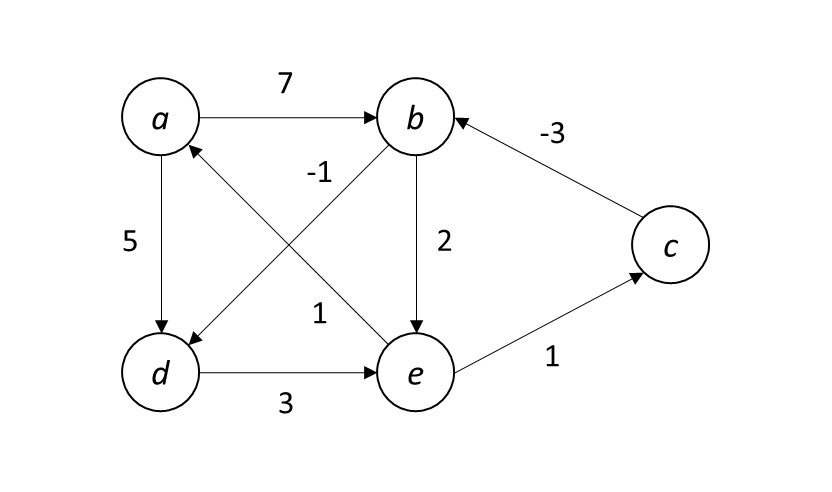

En primer lugar, inicializamos la distancia de cada vértice del grafo, considerando como punto de partida el nodo $a$:

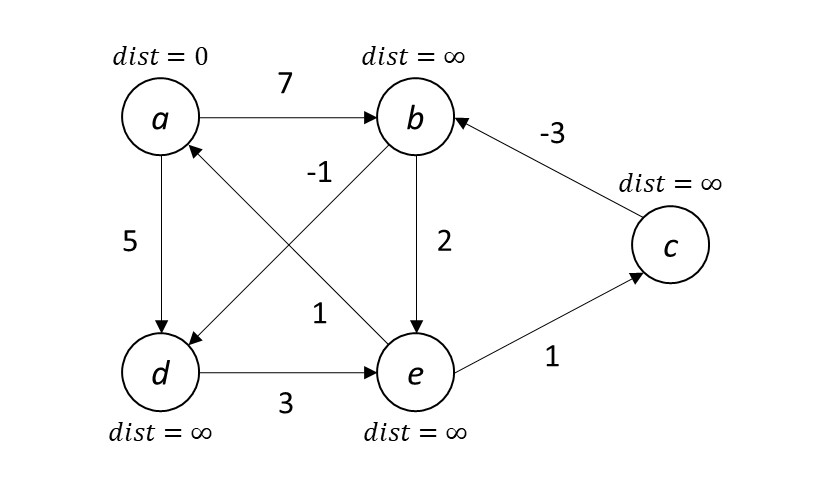

Luego, iteramos por cada uno de los arcos del grafo. Para este ejemplo, asumiremos que los arcos se recorren en orden alfabético.

Al pasar por el arco $(a, b)$, calculamos el valor de la distancia para el nodo de llegada.

$\text{dist}(a, b) = \text{dist}(a, a) + w(a, b) = 0 + 7 = 7$

Como $7 < ∞$, actualizamos el valor de la distancia. Repetimos este paso para el arco $(a, d)$

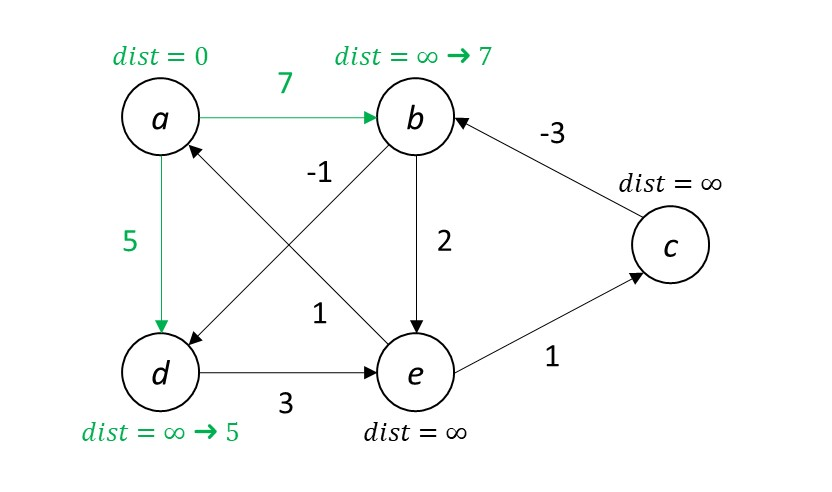

Continuamos con el arco $(b, d)$. En este caso, notamos que al calcular la distancia, obtenemos un valor mayor al previamente guardado.

$\text{dist}(b, d) = \text{dist}(a, b) + w(b, d) = 7 + (-1) = 6$

Como $5 > 6$, mantenemos el valor anterior.

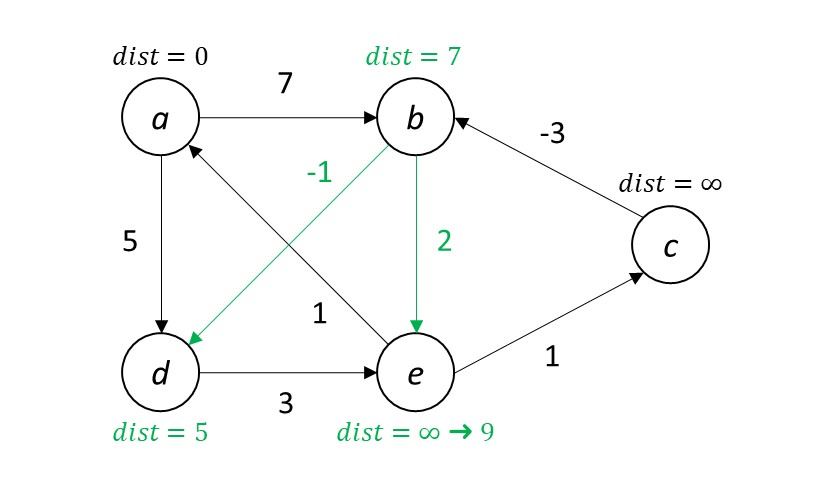

Repetimos este paso para el resto de arcos del grafo:

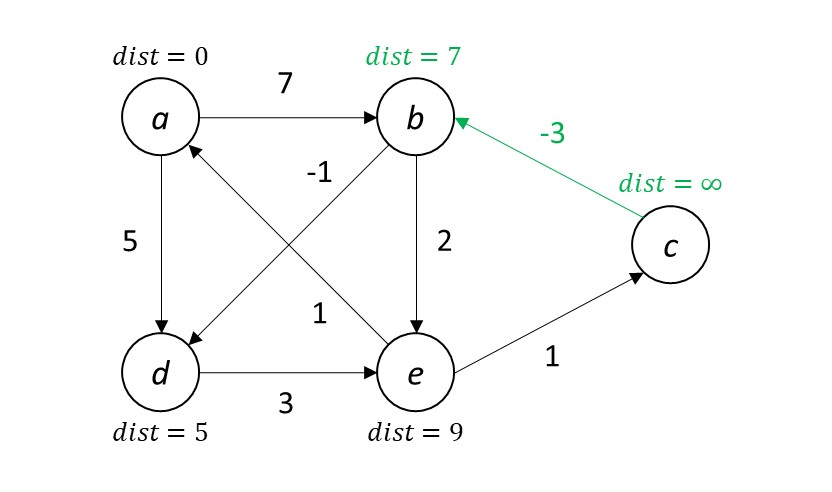

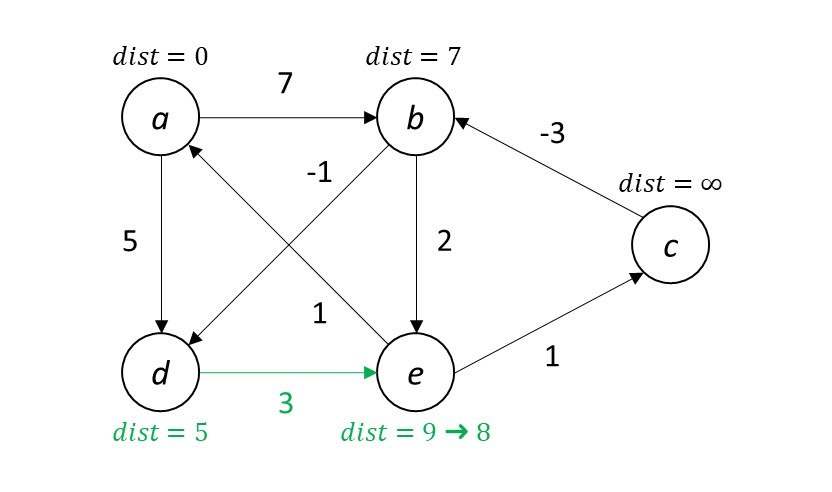

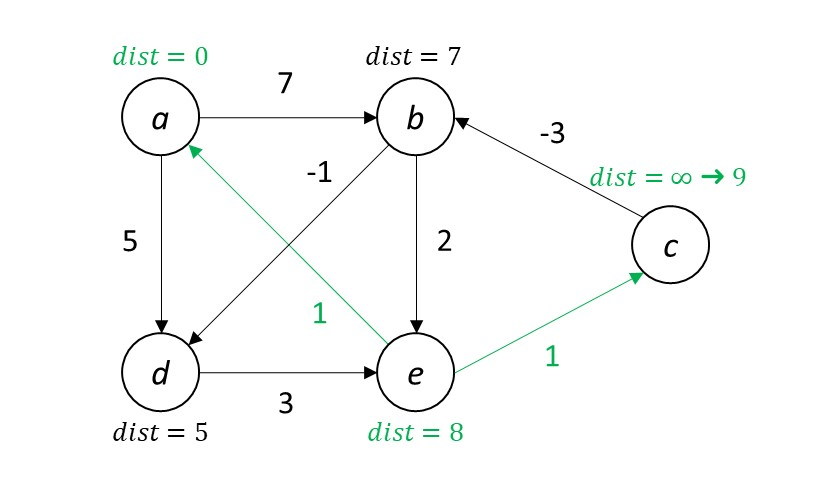

Al finalizar la primera iteración, obtenemos las siguientes distancias:

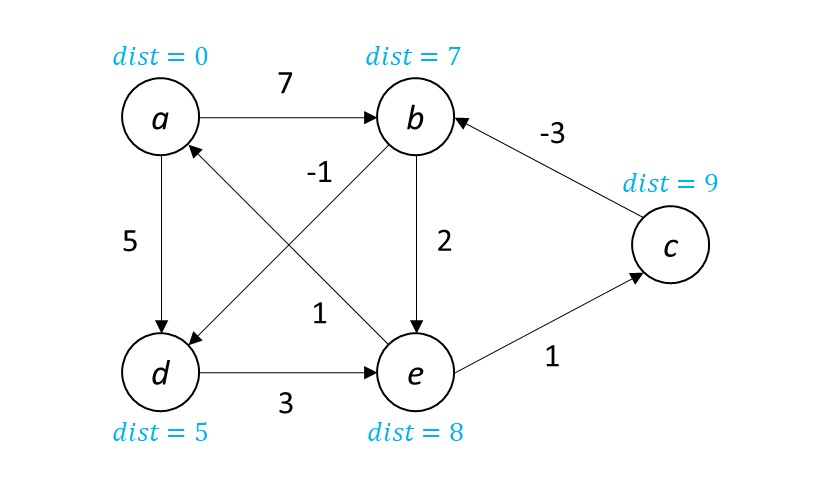

En la siguiente iteración, actualizamos los valores que sean necesarios:

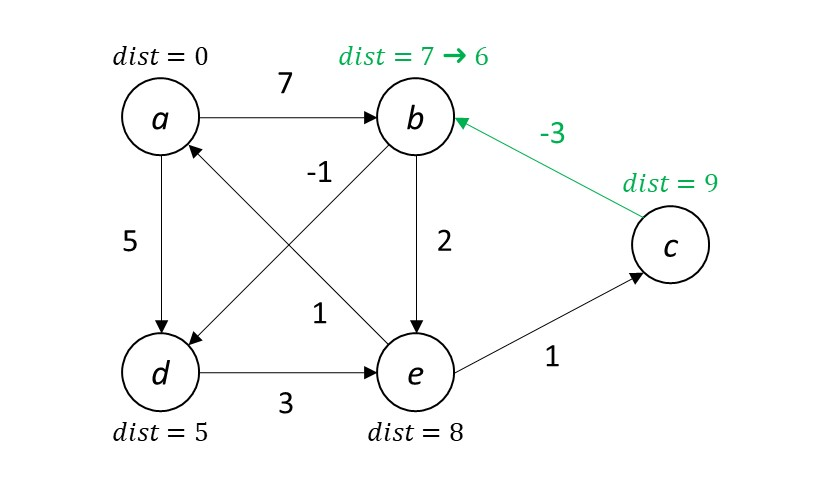

Continuamos iterando hasta completar las $n-1$ iteraciones, o convenientemente hasta que no ocurran más cambios. Finalmente, retornamos las distancias obtenidas:

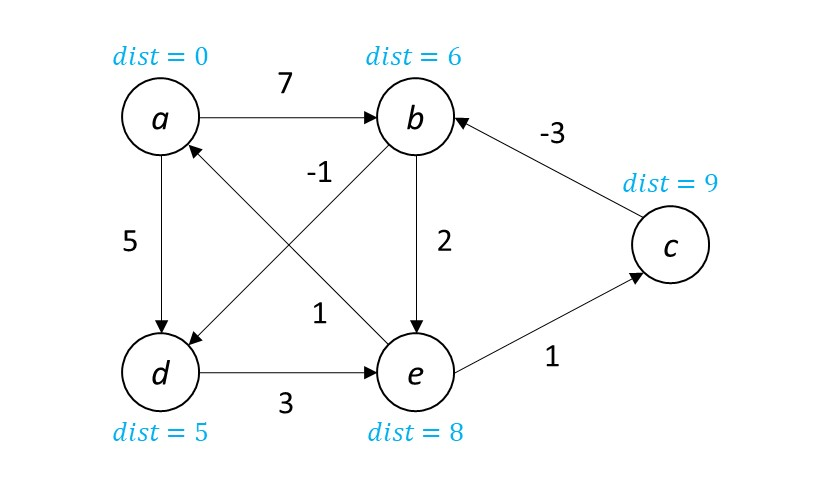

## 2.4. Ejecución del algoritmo paso a paso (`verbose=True`)

Usando la opción `verbose=True`, podemos ver lo que ocurre en cada paso de ambos algoritmos:

In [50]:
import networkx as nx
import string
import random

def graph_instance_creator(n, p, negative_weights):
  graph = nx.gnp_random_graph(n, p, 1, True)
  weighted_edges = list()

  if negative_weights: min, max = -3, 9
  else: min, max = 1, 9

  for e in graph.edges():
    weight = random.randint(min, max)
    weighted_edges.append((e[0], e[1], weight))

  return create_graph(weighted_edges)

Inicializando nodo 0 con distancia 0
Inicializando resto de nodos con distancia infinita

Iteración 1:

Calculando distancia al nodo 1 con nodo predecesor 0: 0 + -3 = -3
Distancia (-3) es menor a la actual (-3). Actualizando...
Calculando distancia al nodo 4 con nodo predecesor 0: 0 + 4 = 4
Distancia (4) es menor a la actual (4). Actualizando...
Calculando distancia al nodo 2 con nodo predecesor 1: -3 + 5 = 2
Distancia (2) es menor a la actual (2). Actualizando...
Calculando distancia al nodo 0 con nodo predecesor 4: 4 + 0 = 4
Distancia (4) es mayor a la actual (4)
Calculando distancia al nodo 3 con nodo predecesor 4: 4 + 0 = 4
Distancia (4) es menor a la actual (4). Actualizando...
Calculando distancia al nodo 0 con nodo predecesor 2: 2 + 6 = 8
Distancia (8) es mayor a la actual (8)
Calculando distancia al nodo 1 con nodo predecesor 2: 2 + 1 = 3
Distancia (3) es mayor a la actual (3)
Calculando distancia al nodo 4 con nodo predecesor 2: 2 + 3 = 5
Distancia (5) es mayor a la actual (5)

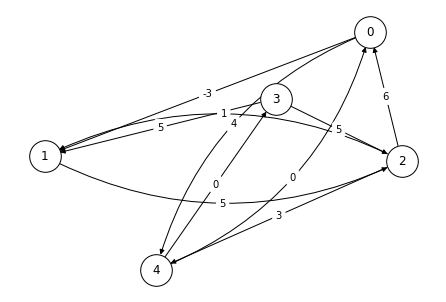

In [ ]:
graph = graph_instance_creator(5, 0.45, True)
d = bellman_ford(graph, 0, True, True)

Inicializando montículo para guardar los nodos
Insertando nodos 1, 4, 2, 3 con distancia infinita
Insertando nodo 0 con distancia 0

Visitando nodo 0
Obteniendo nodos adyacentes: 1, 4
Calculando distancia al nodo 1: 0 + 4 = 4
Distancia (4) es menor a la actual (inf). Actualizando...
Calculando distancia al nodo 4: 0 + 5 = 5
Distancia (5) es menor a la actual (inf). Actualizando...

Visitando nodo 1
Obteniendo nodos adyacentes: 2
Calculando distancia al nodo 2: 4 + 7 = 11
Distancia (11) es menor a la actual (inf). Actualizando...

Visitando nodo 4
Obteniendo nodos adyacentes: 0, 3
Saltando nodo 0 ya visitado
Calculando distancia al nodo 3: 5 + 8 = 13
Distancia (13) es menor a la actual (inf). Actualizando...

Visitando nodo 2
Obteniendo nodos adyacentes: 0, 1, 4
Saltando nodo 0 ya visitado
Saltando nodo 1 ya visitado
Saltando nodo 4 ya visitado

Visitando nodo 3
Obteniendo nodos adyacentes: 1, 2
Saltando nodo 1 ya visitado
Saltando nodo 2 ya visitado

Distancias: [0, 4, 11, 13, 5]


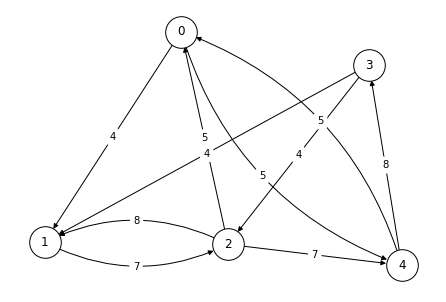

In [55]:
graph = graph_instance_creator(5, 0.45, False)
d = dijkstra(graph, 0, True, True)

# 3. Correctitud

### **Teorema 1: Correctitud del algoritmo Bellman-Ford**

*El algoritmo **Bellman-Ford** calcula correctamente la distancia de un nodo inicial $s$ al resto de nodos de un grafo $G$ sin ciclos negativos.*

## Prueba del Teorema

### Hipótesis inductiva

*En la $k$-ésima iteración del algoritmo, la distancia de $s$ a cada nodo $v$ separado como máximo por $k$ arcos es igual a la distancia del camino más corto.*

### Prueba por inducción

**Caso base**

Para $k = 0$, el valor de la distancia para el nodo $s$ es 0, mientras que la distancia al resto de nodos es $∞$. Esto es correcto, pues este caso implica pasar como máximo por 0 arcos. Como no es posible llegar al resto de vértices, decimos que la distancia es $∞$.

**Paso inductivo**

Al comienzo de la iteración $k+1$, por inducción sabemos que la distancia actual de $s$ a $v$ corresponde a la distancia del camino más corto a este nodo pasando como máximo por $k$ arcos. Sin embargo, si consideramos un arco adicional, podría existir un camino que optimice esta distancia. 

Consideremos un nodo $u$ predecesor de $v$ tal que $s \leadsto u$ está formado por $k$ arcos. Al agregar el arco $(u, v)$ a este camino, se forma un nuevo camino $s \leadsto v$ con $k+1$ arcos. Por inducción, sabemos que la distancia calculada para cada nodo $u$ es óptima. Luego, al sumar el peso del arco $(u, v)$ obtendremos la distancia de $s \leadsto v$ pasando por el nodo $u$. Teniendo esto en cuenta, existen dos casos:

1. El camino más corto $s \leadsto v$ está formado por $k$ arcos o menos. En este caso, $v$ se mantiene con el valor obtenido en la iteración anterior.

2. El camino más corto $s \leadsto v$ está formado por $k$ arcos, más un arco $(u, v)$. En este caso, sabemos que un arco $(u, v)$ será el que minimice la distancia $s \leadsto v$. Al finalizar la iteración, se habrá calculado un nuevo valor óptimo para $\text{dist}(s, v)$.

### Corolario

*La cantidad mínima de iteraciones necesarias para encontrar la distancia óptima a cada vértice es $V-1$*

En el peor caso, para cualquier nodo $v$ del grafo, el camino más corto $s \leadsto v$ estará formado como máximo por $V-1$ arcos, si y solo si no existen ciclos negativos. Esto se puede visualizar fácilmente en la siguiente imagen:

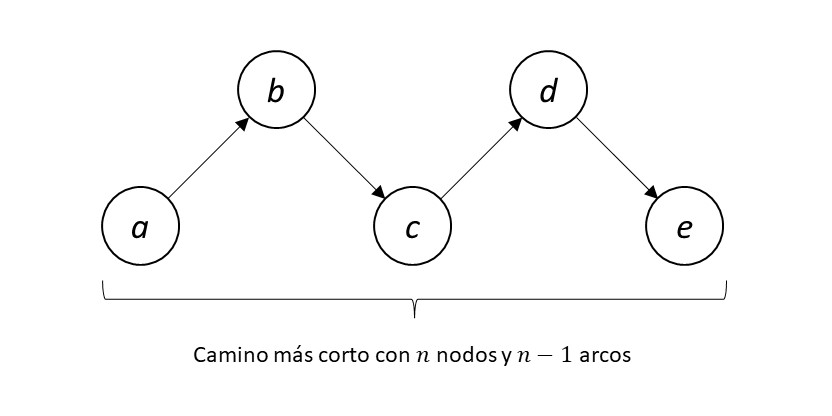

Como en cada iteración se encuentra el camino más corto para cada vértice pasando como máximo por $k$ arcos, en la iteración $V - 1$ se encontrará la distancia a todos los vértices separados por esta cantidad de arcos.

Observemos que el algoritmo realiza una última iteración para verificar la existencia de ciclos negativos. Hasta este paso, habremos calculado la distancia mínima a cada nodo del grafo, por lo cual si obtenemos un valor menor durante esta iteración, implica la existencia de al menos un ciclo negativo. 

Habiendo demostrado la hipótesis y el corolario planteado, queda demostrada la correctitud del algoritmo **Bellman-Ford**. $\Box$

# 4. Tiempo de ejecución

### **Teorema 2: Tiempo de ejecución del algoritmo Bellman-Ford**

*El algoritmo **Bellman-Ford** tiene un un tiempo de ejecución $O(V \cdot E)$ en el caso promedio, $O(E)$ en el mejor caso y $O(V^3)$ en el peor caso.*

## Prueba del Teorema

### Caso promedio

Podemos obtener fácilmente la complejidad temporal promedio analizando cada operación realizada por el algoritmo:

1. Inicializar la distancia para cada nodo del grafo tiene un tiempo de ejecución $O(V)$

2. Realizar $V - 1$ iteraciones pasando por todos los arcos del grafo tiene un tiempo de ejecución $O(V \cdot E)$

3. Realizar una iteración adicional por todos los arcos para verificar la existencia de ciclos negativos tiene un tiempo de ejecución $O(E)$

Luego, la complejidad temporal del algoritmo es $O(V) + O(V \cdot E) + O(E) = O(V \cdot E)$

### Mejor caso

El mejor caso ocurrirá cuando un grafo se recorra de izquierda a derecha, de manera que la distancia a cada nodo predecesor $u$ siempre se calculará correctamente, y podremos calcular de inmediato la distancia óptima a un nodo $v$.

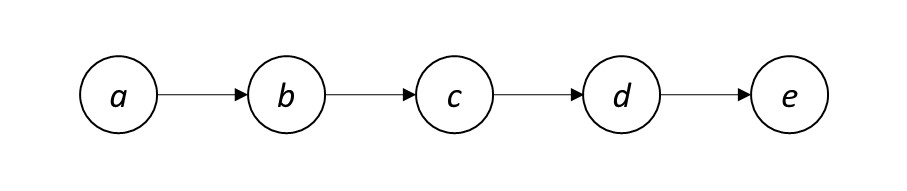

En este caso, solo se necesitarán 2 iteraciones por los arcos del grafo: una para calcular los valores óptimos, y otra para verificar que no ocurran más cambios en las distancias. Por lo tanto, la complejidad temporal de este caso es $O(E)$.

### Peor caso

El peor caso ocurrirá cuando el grafo de entrada contenga un número de arcos con complejidad cuadrática. Un ejemplo de esto son los **grafos completos**, en donde cada par de vértices está conectado por una arista.

La cantidad de conexiones para un grafo completo no dirigido se calcula como $V(V-1)/2$, mientras que para un grafo dirigido el número de arcos es $V(V-1)$

<br>
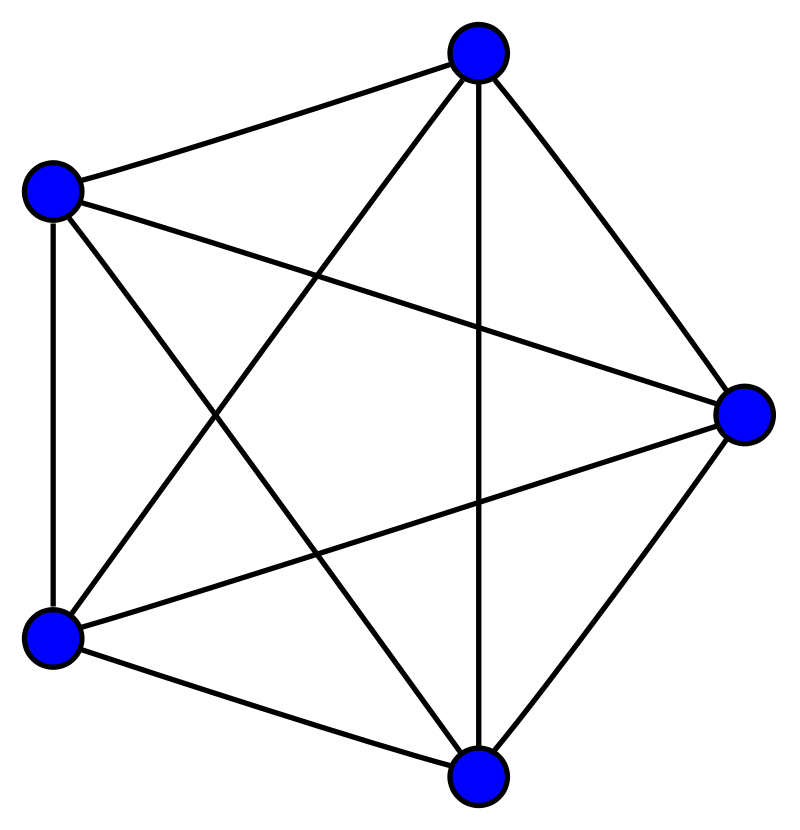
<br>

Además, si el grafo contiene ciclos negativos, la cantidad de iteraciones será $V - 1$. Por lo tanto, la complejidad temporal de este caso es $O(V) \cdot O(V^2) = O(V^3)$


### **Teorema 3: Tiempo de ejecución del algoritmo de Dijkstra**

*El algoritmo **Dijkstra** tiene un un tiempo de ejecución $O(E \log{V})$ al utilizar una cola de prioridad implementada con un montículo binario.*

## Prueba del Teorema

Al igual que en la demostración anterior, podemos obtener la complejidad temporal del algoritmo analizando el tiempo de ejecución paso por paso:

1. Insertar los nodos en la cola de prioridad tiene un tiempo de ejecución $O(V) \cdot O(\log{V}) = O(V \log{V})$

2. Obtener y eliminar uno por uno los elementos menores del montículo tiene un tiempo de ejecución $O(V) \cdot O(\log{V}) = O(V \log{V})$

3. Obtener los nodos adyacentes de cada nodo del grafo, implica pasar por todos sus arcos. Por lo tanto, calcular la distancia a todos los nodos adyacentes y volver a insertarlos en el montículo tiene un tiempo de ejecución $O(E) \cdot O(\log{V}) = O(E \log{V})$

Notar que la implementación del algoritmo presentada en este informe permite la existencia de nodos duplicados en el montículo. Esto no cambia la complejidad de las operaciones, que seguirá siendo $O(\log{V})$, sin embargo, la eficiencia se verá afectada por una constante oculta mayor. Algunas implementaciones del montículo binario consideran una operación `decrease_key`, que soluciona el problema de los nodos duplicados permitiendo actualizar la prioridad de los nodos ya insertados.

Luego, según el análisis previo, obtenemos que la complejidad del algoritmo es:

$O(V \log{V}) + O(V \log{V}) + O(E \log{V}) = O(E \log{V})$

Por lo tanto, queda demostrado el teorema. $\Box$

# 5. Experimentos

## 5.1 Tiempo de ejecución de Bellman-Ford

En este experimento se medirá el tiempo de ejecución experimental del algoritmo Bellman-Ford. Para ello, se calculará el tiempo promedio del algoritmo para 25 instancias distintas de grafos, para cada tamaño $n$ de entrada en el rango de 5 a 50.

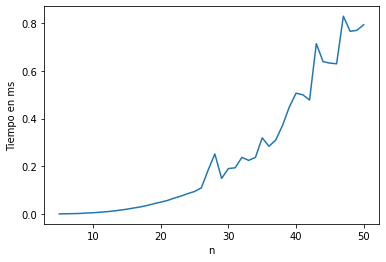

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import repeat

x = []; y = [];

for n in range(5,51):
  t = 0

  for i in range(25):
    G = graph_instance_creator(n, 0.45, True)
    t += repeat(setup="from __main__ import bellman_ford", stmt=lambda: bellman_ford(G, 0), repeat=1, number=10)[0]

  prom = t / 25
  x.append(n)
  y.append(prom)

plt.plot(x,y)

plt.xlabel('n')
plt.ylabel('Tiempo en ms')
plt.show()

### Análisis de resultados

Como se puede apreciar en el gráfico, el tiempo de ejecución del algoritmo sigue una curva polinomial. Sabemos que la cantidad de arcos de un grafo en que todos sus vértices están conectados, es como mínimo $V - 1$ y como máximo $V(V - 1)$. Considerando que la complejidad temporal del algoritmo en el caso general es $O(V \cdot E)$, esta puede ser de orden $O(V^2)$ o $O(V^3)$ dependiendo del caso. 

En el caso particular del generador de instancias utilizado en este informe, la cantidad de arcos del grafo se calcula de manera aproximada con la fórmula $p \cdot V(V-1)$, donde $p$ corresponde a la probabilidad de generación de los arcos del grafo en relación a la máxima cantidad de conexiones posibles. Por lo tanto, sin importar el valor escogido para $p$ (0.45 para este experimento), la complejidad del algoritmo será de orden $O(V^3)$

## 5.2 Comparación de tiempo entre Bellman-Ford y Dijkstra

El segundo experimento consiste en comparar el tiempo de ejecución de los algoritmos de Dijkstra y Bellman-Ford. El valor de entrada para ambos algoritmos consistirá en un grafo con arcos no negativos, para cada tamaño $n$ de entrada en el rango de 5 a 100. 

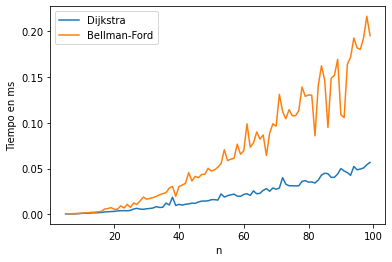

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import repeat

x=[]; y1=[]; y2=[]

for n in range(5,100):
  G = graph_instance_creator(n, False)

  t1 = repeat(setup="from __main__ import dijkstra", stmt=lambda: dijkstra(G, 0), repeat=1, number=10)
  t2 = repeat(setup="from __main__ import bellman_ford", stmt=lambda: bellman_ford(G, 0), repeat=1, number=10)

  x.append(n)
  y1.append(t1)
  y2.append(t2)

plt.plot(x,y1)
plt.plot(x,y2)
plt.legend(["Dijkstra", "Bellman-Ford"])

plt.xlabel('n')
plt.ylabel('Tiempo en ms')
plt.show()

### Análisis de resultados

Como era de esperar, el algoritmo de Dijkstra presenta un mejor desempeño que Bellman-Ford. Al comparar las complejidades temporales de ambos algoritmos, se cumple que $O(E \log V) < O(V \cdot E)$, lo cual coincide con los resultados observados en el gráfico.